In [ ]:
import torch 
import torch.nn as nn
from intersection_over_union import intersection_over_union

The complete loss function is:


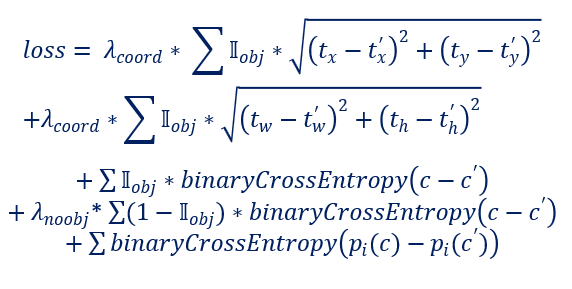

In [ ]:
class Yolov3Loss(nn.Module):
  def __init__(self):
    super().__init__()
    # we have different loss functions each one to calculate the loss for 
    # a specific element.
    self.mse= nn.MSELoss() #for the box predictions.
    self.bce= nn.BCEWithLogitsLoss() # this applies both binary cross entropy and sigmoid
    self.entropy = nn.CrossEntropyLoss() #we used cross entropy because we have one label per box.
    self.sigmoid= nn.Sigmoid()

    # we want to wight each element of the loss function 
    # so we defined several constant numbers to mulipuly different 
    #elements of the loss function with them.
    ##those values are NOT from the original paper###
    self.lambda_class = 1
    self.lambda_noobj = 10
    self.lambda_obj = 1
    self.lambda_box = 10

  def forward(self, predictions, target, anchors):
    #we will compute the loss for a single scale
    #so for every forward pass we will call this three times.

    #check where is the object and the noobject in the target, to make sure that we are 
    #only taking values equal to 0 or 1.
    ## because we ignored values when IOU is greater than 0.5
    obj= target[...,0] == 1 #binary value
    noobj= target[...,0]==0

    ####################
    #   NO Object Loss #
    ####################
    # we only apply the loss when there is noobject
    no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

    ####################
    #    Object Loss   #
    ####################
    #we only apply this loss for the cells and anchor boxes that has an object
    # we reshape to match the dimentins of the height and width 
    # because we want to be able to muliply and broadcast "from th fprmula p_w* exp(t_w)"
    anchors = anchors.reshape(1, 3, 1, 1, 2) 
    # we use sigmoid for the x,y coordinates to mzke them in the range [0,1]
    #we use torch.exp for the height and width, and multiply them with anchors
    # and concatunate the prevous two over the -1 dimention.
    box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
    ious= intersection_over_union(box_preds[obj], target[...,1:5][obj]).detach()
    #only boxes and anchores that has an object
    object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

    #########################
    # box coordinate Loss   #
    #########################

    #to make x and y in the range [0,1]
    predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) 
    #changing the width and height to the same format as the predictions.
    target[..., 3:5] = torch.log((0.0000001 + target[..., 3:5] / anchors))#this is hte inverse function of torch.exp(predictions[..., 3:5]) * anchors]
    # we also added a small value to make sure that the derivative doesn't have 1/0'

    # compute mse loss for boxes that has an object only
    box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

    ####################
    #    Class Loss    #
    ####################
    #finally predict the classes for the places that has objects using the cross entropy loss
    class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )
        
    loss= (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )
    return loss


